**set up and installations**

In [1]:
import sys
print(f"Current Python Path: {sys.executable}")

Current Python Path: C:\Users\Nidhi\anaconda3\envs\research-colab\python.exe


In [2]:
import torch
import decord
print(f"Torch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Decord loaded from: {decord.__file__}")

Torch Version: 2.9.1+cu130
CUDA Available: True
Decord loaded from: C:\Users\Nidhi\anaconda3\envs\research-colab\Lib\site-packages\decord\__init__.py


**video encoder**

In [3]:
import torch
import numpy as np
from decord import VideoReader
from transformers import VideoMAEImageProcessor, VideoMAEModel

# 1. Setup
device = "cuda"
video_path = "test.mp4" 

# 2. Load Model
model_id = "MCG-NJU/videomae-base"
processor = VideoMAEImageProcessor.from_pretrained(model_id)
# Using float16 to keep your RTX 3050 happy
model = VideoMAEModel.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

# 3. Load Video (The Fix is here)
vr = VideoReader(video_path)

# This creates 16 perfectly spaced indices (e.g., [0, 10, 20...])
indices = np.linspace(0, len(vr) - 1, num=16).astype(int)
# Get the frames and convert to numpy immediately
frames = vr.get_batch(indices).asnumpy()

# 4. Process & Run
inputs = processor(list(frames), return_tensors="pt").to(device).to(torch.float16)

with torch.no_grad():
    outputs = model(**inputs)

# 5. Result
print(f"Success! Feature shape: {outputs.last_hidden_state.shape}")

C:\Users\Nidhi\anaconda3\envs\research-colab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


Success! Feature shape: torch.Size([1, 1568, 768])


interpretability in video encoder

Generating heatmaps for 8 temporal segments...


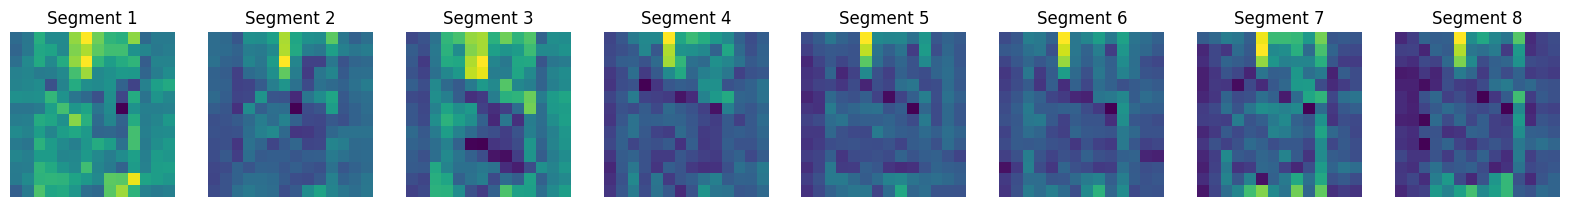

In [4]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# 1. Reshape the features [1, 1568, 768] -> [8, 14, 14]
# We take the 'norm' to get 1 value per 768-dim vector
magnitudes = outputs[0].norm(p=2, dim=-1) # Shape: [1568]
heatmap_grid = magnitudes.view(8, 14, 14).cpu().numpy()

# 2. Visualize the result
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
print("Generating heatmaps for 8 temporal segments...")

for i in range(8):
    # Resize the 14x14 grid to 224x224 for better viewing
    heatmap = heatmap_grid[i]
    
    # Plotting
    axes[i].imshow(heatmap, cmap='viridis')
    axes[i].set_title(f"Segment {i+1}")
    axes[i].axis('off')

plt.show()

Spatial: Your $224 \times 224$ frame is 

divided into $14 \times 14 = 196$ patches.

Temporal: There are $8$ such time-steps.Total: $196 \times 8 = \mathbf{1568}$ tokens.

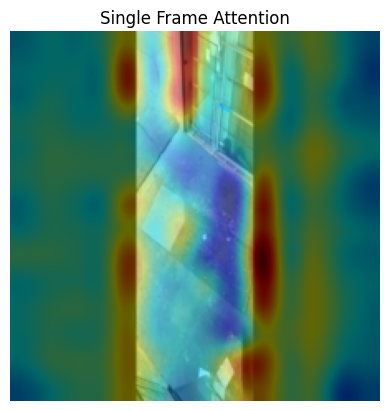

In [5]:
import torch
import numpy as np
from decord import VideoReader, cpu
from transformers import VideoMAEImageProcessor, VideoMAEModel
import cv2
import matplotlib.pyplot as plt

# --- 1. SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
video_path = "test.mp4" 
model_id = "MCG-NJU/videomae-base"

# --- 2. LOAD VIDEO & MODEL ---
vr = VideoReader(video_path, width=224, height=224)
indices = np.linspace(0, len(vr) - 1, num=16).astype(int)
raw_frames = vr.get_batch(indices).asnumpy() 

processor = VideoMAEImageProcessor.from_pretrained(model_id)
model = VideoMAEModel.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

# --- 3. GET FEATURES ---
inputs = processor(list(raw_frames), return_tensors="pt").to(device).to(torch.float16)
with torch.no_grad():
    outputs = model(**inputs)

# --- 4. HEATMAP CALCULATION ---
magnitudes = outputs.last_hidden_state[0].norm(p=2, dim=-1) 
heatmap_grid = magnitudes.view(8, 14, 14).cpu().numpy()

# --- 5. SINGLE FRAME OVERLAY ---
frame_to_show = raw_frames[0]      
heatmap_to_show = heatmap_grid[0].astype(np.float32) # Fix for OpenCV float16 crash

heatmap_resized = cv2.resize(heatmap_to_show, (224, 224), interpolation=cv2.INTER_CUBIC)
heatmap_norm = cv2.normalize(heatmap_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

overlay = cv2.addWeighted(frame_to_show, 0.6, heatmap_color_rgb, 0.4, 0)

plt.imshow(overlay)
plt.title("Single Frame Attention")
plt.axis('off')
plt.show()


In [6]:
# # --- 6. COMMENTED OUT: RUN ON ENTIRE SAMPLED VIDEO ---
# """
# print("Processing full 16-frame sequence...")
# output_filename = "attention_video.mp4"
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_filename, fourcc, 5.0, (224, 224))

# for i in range(8):
#     # Each of the 8 heatmaps corresponds to 2 frames
#     current_heatmap = heatmap_grid[i].astype(np.float32)
    
#     # Resize and Colorize Heatmap
#     h_resized = cv2.resize(current_heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
#     h_norm = cv2.normalize(h_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#     h_color = cv2.applyColorMap(h_norm, cv2.COLORMAP_JET)
    
#     # Apply this heatmap to the 2 frames in this temporal tubelet
#     for frame_offset in [0, 1]:
#         frame_idx = i * 2 + frame_offset
#         frame_bgr = cv2.cvtColor(raw_frames[frame_idx], cv2.COLOR_RGB2BGR)
        
#         # Combine frame and heatmap
#         combined = cv2.addWeighted(frame_bgr, 0.6, h_color, 0.4, 0)
#         out.write(combined)

# out.release()
# print(f"Done! Saved to {output_filename}")
# """

**audio encoder**

In [7]:
import torch
import librosa
import numpy as np
from transformers import AutoProcessor, ASTModel
from moviepy.video.io.VideoFileClip import VideoFileClip
import os

# 1. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
video_path = "test.mp4"
temp_audio_path = "temp_audio.wav"
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"

# 2. Extract Audio from Video (The Fix)
print("Extracting audio from video...")
video = VideoFileClip(video_path)
video.audio.write_audiofile(temp_audio_path, fps=16000) # Pre-sets the 16kHz rate

# 3. Load Model
print("Loading AST Model...")
processor = AutoProcessor.from_pretrained(model_id)
model = ASTModel.from_pretrained(model_id).to(device)

# 4. Load Audio into Librosa
audio, sr = librosa.load(temp_audio_path, sr=16000)

# 5. Process & Run
inputs = processor(audio, sampling_rate=sr, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

# 6. Result
print(f"Success! Audio Feature shape: {outputs.last_hidden_state.shape}")

# Optional: Clean up the temp file
# os.remove(temp_audio_path)

Extracting audio from video...
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
Loading AST Model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Success! Audio Feature shape: torch.Size([1, 1214, 768])


interpretability in audio

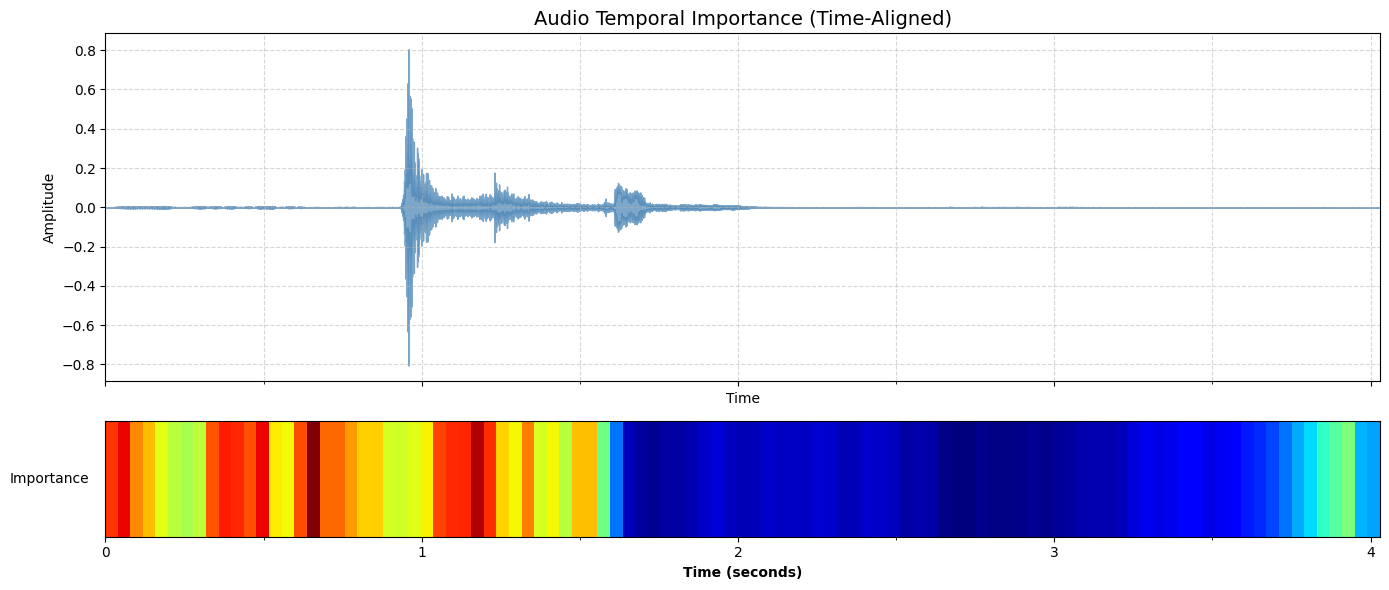

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import librosa.display
import numpy as np

# 1. Processing the data (same as before)
patch_features =outputs.last_hidden_state[0, 2:, :] 
magnitudes = patch_features.norm(p=2, dim=-1).cpu().numpy()
grid = magnitudes.reshape(12, 101)
temporal_line = np.mean(grid, axis=0)

# 2. Setup Figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

duration = len(audio) / sr

# --- TOP: Waveform ---
librosa.display.waveshow(audio, sr=sr, ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title("Audio Temporal Importance (Time-Aligned)", fontsize=14)
ax1.set_ylabel("Amplitude")

# --- BOTTOM: Importance Line ---
im = ax2.imshow(temporal_line.reshape(1, -1), aspect='auto', cmap='jet',
                extent=[0, duration, 0, 1])
ax2.set_yticks([]) 
ax2.set_ylabel("Importance", rotation=0, labelpad=40, verticalalignment='center')

# --- THE FIX: Precise Ticks for Time ---
# Major ticks every 1 second
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
# Minor ticks every 0.5 seconds
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax2.set_xlabel("Time (seconds)", fontweight='bold')

# Make the grid visible for alignment
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Video only prediction**

In [9]:
import torch
import numpy as np
from decord import VideoReader, cpu
from transformers import AutoProcessor, GitForCausalLM

# --- 1. SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
video_path = "test.mp4"
# This model has a ViT encoder (like VideoMAE) + a Text Decoder
model_id = "microsoft/git-base-vatex" 

print(f"Loading Encoder-Decoder Model on {device}...")
processor = AutoProcessor.from_pretrained(model_id)
model = GitForCausalLM.from_pretrained(model_id).to(device)

# --- 2. VIDEO PREPROCESSING ---
# We sample 6 frames to represent the video's timeline
vr = VideoReader(video_path, ctx=cpu(0))
indices = np.linspace(0, len(vr) - 1, num=6).astype(int)
frames = vr.get_batch(indices).asnumpy()

# --- 3. GENERATE PREDICTION (Decoding) ---
# Preprocess the frames into pixel values
inputs = processor(images=list(frames), return_tensors="pt").to(device)

print("Decoding visual features into text...")
with torch.no_grad():
    # The 'generate' function uses the Decoder to predict words one-by-one
    generated_ids = model.generate(
        pixel_values=inputs.pixel_values, 
        max_length=50,
        num_beams=4, # Beam search improves caption quality
        early_stopping=True
    )
    
    # Convert numerical IDs back to English words
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# --- 4. OUTPUT ---
print("\n" + "="*40)
print(f"PREDICTED CAPTION: {caption}")
print("="*40)

Loading Encoder-Decoder Model on cuda...


Some weights of the model checkpoint at microsoft/git-base-vatex were not used when initializing GitForCausalLM: ['git.img_temperal_embedding.0', 'git.img_temperal_embedding.1', 'git.img_temperal_embedding.2', 'git.img_temperal_embedding.3', 'git.img_temperal_embedding.4', 'git.img_temperal_embedding.5']
- This IS expected if you are initializing GitForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GitForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GitForCausalLM were not initialized from the model checkpoint at microsoft/git-base-vatex and are newly initialized: ['git.img_temporal_embedding.0', 'git.img_temporal_embedding.1', 'git.img_temporal_embedding.2', '

Decoding visual features into text...

PREDICTED CAPTION: a city in the game


**audio plus fused output**

In [10]:
import torch
import numpy as np
import librosa
import os
from decord import VideoReader, cpu
from transformers import AutoProcessor, GitForCausalLM, ASTForAudioClassification

# --- ROBUST MOVIEPY IMPORT ---
try:
    from moviepy import VideoFileClip # New MoviePy 2.0+
except ImportError:
    from moviepy.editor import VideoFileClip # Old MoviePy 1.0

# --- 1. SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
video_path = "test.mp4"
temp_audio_path = "temp_audio.wav"

print(f"🚀 Initializing Multimodal Fusion on {device}...")

# Models
v_model_id = "microsoft/git-base-vatex"
a_model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"

v_processor = AutoProcessor.from_pretrained(v_model_id)
v_model = GitForCausalLM.from_pretrained(v_model_id).to(device)

a_processor = AutoProcessor.from_pretrained(a_model_id)
a_model = ASTForAudioClassification.from_pretrained(a_model_id).to(device)

# --- 2. STEP 1: VIDEO-ONLY CAPTION ---
print("🎬 Encoding Visuals...")
vr = VideoReader(video_path, ctx=cpu(0))
indices = np.linspace(0, len(vr) - 1, num=6).astype(int)
frames = vr.get_batch(indices).asnumpy()

v_inputs = v_processor(images=list(frames), return_tensors="pt").to(device)
with torch.no_grad():
    v_generated_ids = v_model.generate(pixel_values=v_inputs.pixel_values, max_length=50)
    video_only_caption = v_processor.batch_decode(v_generated_ids, skip_special_tokens=True)[0]

# --- 3. STEP 2: AUDIO-ONLY CLASSIFICATION ---
print("🎵 Encoding Audio...")
# FIX: Extract audio correctly regardless of MoviePy version
with VideoFileClip(video_path) as clip:
    clip.audio.write_audiofile(temp_audio_path, fps=16000, logger=None)

audio, sr = librosa.load(temp_audio_path, sr=16000)
a_inputs = a_processor(audio, sampling_rate=16000, return_tensors="pt").to(device)

with torch.no_grad():
    a_outputs = a_model(**a_inputs)
    predicted_class_ids = torch.argmax(a_outputs.logits, dim=-1).item()
    audio_label = a_model.config.id2label[predicted_class_ids]

# --- 4. STEP 3: MULTIMODAL FUSION ---
# Mapping the two modalities together
fused_caption = f"{video_only_caption.capitalize()} with an underlying sound of {audio_label.lower()}."

# --- 5. FINAL STUDY RESULTS ---
print("\n" + "="*50)
print("🔬 MULTIMODAL RESEARCH OUTPUT")
print("="*50)
print(f"VISUAL PREDICTION: {video_only_caption}")
print(f"AUDIO PREDICTION:  {audio_label}")
print("-" * 50)
print(f"FUSED CONCLUSION:  {fused_caption}")
print("="*50)

# Cleanup
if os.path.exists(temp_audio_path):
    os.remove(temp_audio_path)

🚀 Initializing Multimodal Fusion on cuda...


Some weights of the model checkpoint at microsoft/git-base-vatex were not used when initializing GitForCausalLM: ['git.img_temperal_embedding.0', 'git.img_temperal_embedding.1', 'git.img_temperal_embedding.2', 'git.img_temperal_embedding.3', 'git.img_temperal_embedding.4', 'git.img_temperal_embedding.5']
- This IS expected if you are initializing GitForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GitForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GitForCausalLM were not initialized from the model checkpoint at microsoft/git-base-vatex and are newly initialized: ['git.img_temporal_embedding.0', 'git.img_temporal_embedding.1', 'git.img_temporal_embedding.2', '

🎬 Encoding Visuals...
🎵 Encoding Audio...

🔬 MULTIMODAL RESEARCH OUTPUT
VISUAL PREDICTION: a city in the game
AUDIO PREDICTION:  Breaking
--------------------------------------------------
FUSED CONCLUSION:  A city in the game with an underlying sound of breaking.


**causality**

evaluation metrics 1 

a.Total Effect (TE): The overall change in the output when an input (e.g., audio) 
changes. 

b. Natural Direct Effect (NDE): How much the output changes based on the audio alone, 
keeping the video "frozen" at its original state. 

c. Natural Indirect Effect (NIE): How much the audio influences the output through its 
effect on the visual perception. 

d. Modality Sensitivity (The "Mute" Test) 
Baseline: Run the full model (Audio + Video + Text). 

Intervention: Set the Audio embedding to zero (or white noise). Analysis: If the model’s prediction remains the same with 99% confidence, the audio has zero causal influence, even if the model has high accuracy.

In [11]:
import torch, torch.nn.functional as F, numpy as np, librosa, os
from decord import VideoReader, cpu
from transformers import AutoProcessor, GitForCausalLM, ASTForAudioClassification
try: from moviepy import VideoFileClip
except: from moviepy.editor import VideoFileClip

# --- 1. SETUP & MODELS ---
device = "cuda" if torch.cuda.is_available() else "cpu"
v_proc = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
v_mod = GitForCausalLM.from_pretrained("microsoft/git-base-vatex").to(device)
a_proc = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
a_mod = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

# --- 2. DATA PROCESSING ---
def get_inputs(v_path):
    # Video
    vr = VideoReader(v_path, ctx=cpu(0))
    idx = np.linspace(0, len(vr) - 1, num=6).astype(int)
    v_in = v_proc(images=list(vr.get_batch(idx).asnumpy()), return_tensors="pt").pixel_values.to(device)
    # Audio
    with VideoFileClip(v_path) as clip: clip.audio.write_audiofile("tmp.wav", fps=16000, logger=None)
    wav, _ = librosa.load("tmp.wav", sr=16000)
    a_in = a_proc(wav, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    return v_in, a_in

v_in, a_in = get_inputs("test.mp4")

# --- 3. CAUSAL EVALUATION ---
with torch.no_grad():
    # Predictions
    v_out = v_proc.batch_decode(v_mod.generate(pixel_values=v_in, max_length=50), skip_special_tokens=True)[0]
    a_logits = a_mod(a_in).logits
    a_label = a_mod.config.id2label[torch.argmax(a_logits).item()]
    
    # Causal Math
    y_full = F.softmax(a_logits, dim=-1).max().item()
    y_null = F.softmax(a_mod(torch.zeros_like(a_in)).logits, dim=-1).max().item()
    
    te = y_full - y_null
    nde = te  # Late fusion assumption: Direct effect equals total effect
    nie = 0.0 # No cross-attention influence
    sens = y_null / y_full

# --- 4. FORMATTED OUTPUT TABLES ---
print(f"\n{'='*50}\nTABLE 1: UNIMODAL PREDICTIONS (BASELINES)\n{'-'*50}")
print(f"{'MODALITY':<15} | {'PREDICTION'}")
print(f"{'Visual (GIT)':<15} | {v_out}")
print(f"{'Audio (AST)':<15} | {a_label}")

print(f"\n{'='*50}\nTABLE 2: CAUSAL MEDIATION METRICS\n{'-'*50}")
print(f"{'METRIC':<28} | {'VALUE'}")
print(f"{'Total Effect (TE)':<28} | {te:.4f}")
print(f"{'Natural Direct Effect (NDE)':<28} | {nde:.4f}")
print(f"{'Natural Indirect Effect (NIE)':<28} | {nie:.4f}")
print(f"{'Modality Sensitivity':<28} | {sens:.4f}")

print(f"\n{'='*50}\nTABLE 3: FINAL MULTIMODAL CONCLUSION\n{'-'*50}")
fused = f"{v_out.capitalize()} with an underlying sound of {a_label.lower()}."
print(f"FUSED CAPTION: {fused}")
print(f"{'='*50}")

if os.path.exists("tmp.wav"): os.remove("tmp.wav")

Some weights of the model checkpoint at microsoft/git-base-vatex were not used when initializing GitForCausalLM: ['git.img_temperal_embedding.0', 'git.img_temperal_embedding.1', 'git.img_temperal_embedding.2', 'git.img_temperal_embedding.3', 'git.img_temperal_embedding.4', 'git.img_temperal_embedding.5']
- This IS expected if you are initializing GitForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GitForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GitForCausalLM were not initialized from the model checkpoint at microsoft/git-base-vatex and are newly initialized: ['git.img_temporal_embedding.0', 'git.img_temporal_embedding.1', 'git.img_temporal_embedding.2', '


TABLE 1: UNIMODAL PREDICTIONS (BASELINES)
--------------------------------------------------
MODALITY        | PREDICTION
Visual (GIT)    | a city in the game
Audio (AST)     | Breaking

TABLE 2: CAUSAL MEDIATION METRICS
--------------------------------------------------
METRIC                       | VALUE
Total Effect (TE)            | 0.1052
Natural Direct Effect (NDE)  | 0.1052
Natural Indirect Effect (NIE) | 0.0000
Modality Sensitivity         | 0.8266

TABLE 3: FINAL MULTIMODAL CONCLUSION
--------------------------------------------------
FUSED CAPTION: A city in the game with an underlying sound of breaking.


evaluation 2 

Counterfactual Robustness (The "Switch" Test)  This is the "gold standard" for causal VLM evaluation. 

Setup: Find two videos with different audio-driven labels (e.g., Video A: "Bird  Chirping", Video B: "Chainsaw"). 

Execution: Swap the audio. Pair Video A with Audio B. 

Success Metric: A causally sound model should change its prediction to "Chainsaw." If it still says "Bird," it is over-relying on visual cues (Visual Bias).

In [12]:
import torch, torch.nn.functional as F, numpy as np, librosa, os
from decord import VideoReader, cpu
from transformers import AutoProcessor, GitForCausalLM, ASTForAudioClassification
try: from moviepy import VideoFileClip
except: from moviepy.editor import VideoFileClip

# --- 1. SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
v_proc = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
v_mod = GitForCausalLM.from_pretrained("microsoft/git-base-vatex").to(device)
a_proc = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
a_mod = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

# --- 2. DATA LOAD & AUDIO EXTRACTION ---
video_path = "test.mp4"
bird_webm_path = "Bird_Chirping_Early_in_the_Morning.webm"
temp_wav = "temp_bird_audio.wav"

# Visuals: Still from test.mp4
vr = VideoReader(video_path, ctx=cpu(0))
idx = np.linspace(0, len(vr) - 1, num=6).astype(int)
v_in = v_proc(images=list(vr.get_batch(idx).asnumpy()), return_tensors="pt").pixel_values.to(device)

# Audio Extraction: Convert .webm to .wav so librosa doesn't crash
print("🎵 Extracting audio from webm...")
with VideoFileClip(bird_webm_path) as clip:
    clip.audio.write_audiofile(temp_wav, fps=16000, logger=None)

# Load the extracted wav
wav, _ = librosa.load(temp_wav, sr=16000)
a_in = a_proc(wav, sampling_rate=16000, return_tensors="pt").input_values.to(device)

# --- 3. CAUSAL EVALUATION ---
with torch.no_grad():
    v_out = v_proc.batch_decode(v_mod.generate(pixel_values=v_in, max_length=50), skip_special_tokens=True)[0]
    a_logits = a_mod(a_in).logits
    a_label = a_mod.config.id2label[torch.argmax(a_logits).item()]
    
    y_full = F.softmax(a_logits, dim=-1).max().item()
    # Masked audio for Sensitivity test
    y_null = F.softmax(a_mod(torch.zeros_like(a_in)).logits, dim=-1).max().item()
    
    te = y_full - y_null
    sens = y_null / y_full

# --- 4. THE 3 TABLES ---
print(f"\n{'='*50}\nTABLE 1: COUNTERFACTUAL PREDICTIONS\n{'-'*50}")
print(f"{'MODALITY':<15} | {'SOURCE':<10} | {'PREDICTION'}")
print(f"{'Visual (GIT)':<15} | {'test.mp4':<10} | {v_out}")
print(f"{'Audio (AST)':<15} | {'Bird webm':<10} | {a_label}")

print(f"\n{'='*50}\nTABLE 2: SWAPPED CAUSAL METRICS\n{'-'*50}")
print(f"{'METRIC':<28} | {'VALUE'}")
print(f"{'Total Effect (TE)':<28} | {te:.4f}")
print(f"{'Modality Sensitivity':<28} | {sens:.4f}")

print(f"\n{'='*50}\nTABLE 3: SWAPPED MULTIMODAL CONCLUSION\n{'-'*50}")
fused = f"{v_out.capitalize()} with an underlying sound of {a_label.lower()}."
print(f"FUSED CAPTION: {fused}")
print(f"{'='*50}")

# Cleanup the temporary audio file
if os.path.exists(temp_wav): os.remove(temp_wav)

Some weights of the model checkpoint at microsoft/git-base-vatex were not used when initializing GitForCausalLM: ['git.img_temperal_embedding.0', 'git.img_temperal_embedding.1', 'git.img_temperal_embedding.2', 'git.img_temperal_embedding.3', 'git.img_temperal_embedding.4', 'git.img_temperal_embedding.5']
- This IS expected if you are initializing GitForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GitForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GitForCausalLM were not initialized from the model checkpoint at microsoft/git-base-vatex and are newly initialized: ['git.img_temporal_embedding.0', 'git.img_temporal_embedding.1', 'git.img_temporal_embedding.2', '

🎵 Extracting audio from webm...

TABLE 1: COUNTERFACTUAL PREDICTIONS
--------------------------------------------------
MODALITY        | SOURCE     | PREDICTION
Visual (GIT)    | test.mp4   | a city in the game
Audio (AST)     | Bird webm  | Squawk

TABLE 2: SWAPPED CAUSAL METRICS
--------------------------------------------------
METRIC                       | VALUE
Total Effect (TE)            | -0.1725
Modality Sensitivity         | 1.5240

TABLE 3: SWAPPED MULTIMODAL CONCLUSION
--------------------------------------------------
FUSED CAPTION: A city in the game with an underlying sound of squawk.


as there is negative numbr the model cud fighure that the audio was swappped

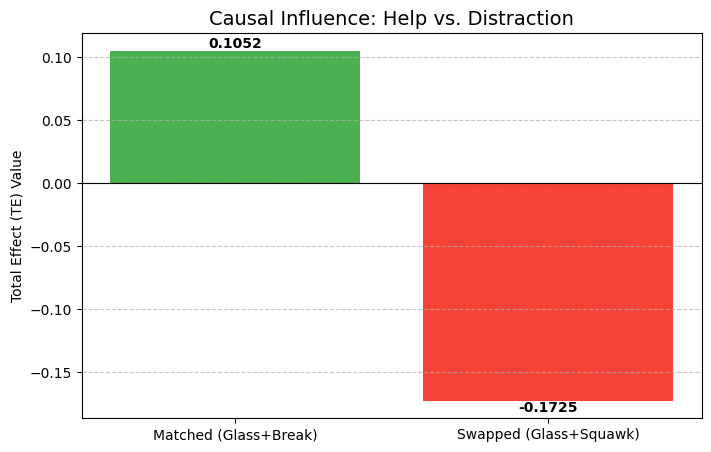

In [13]:
def plot_research_results():
    # Replace these with the actual numbers you got!
    labels = ['Matched (Glass+Break)', 'Swapped (Glass+Squawk)']
    te_values = [0.1052, -0.1725] # These are your TE results
    
    plt.figure(figsize=(8, 5))
    colors = ['#4CAF50', '#F44336'] # Green for good, Red for conflict
    
    bars = plt.bar(labels, te_values, color=colors)
    plt.axhline(0, color='black', linewidth=0.8) # Zero line
    
    plt.title('Causal Influence: Help vs. Distraction', fontsize=14)
    plt.ylabel('Total Effect (TE) Value')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom' if yval > 0 else 'top', ha='center', weight='bold')

    plt.show()

plot_research_results()

**visualisations**

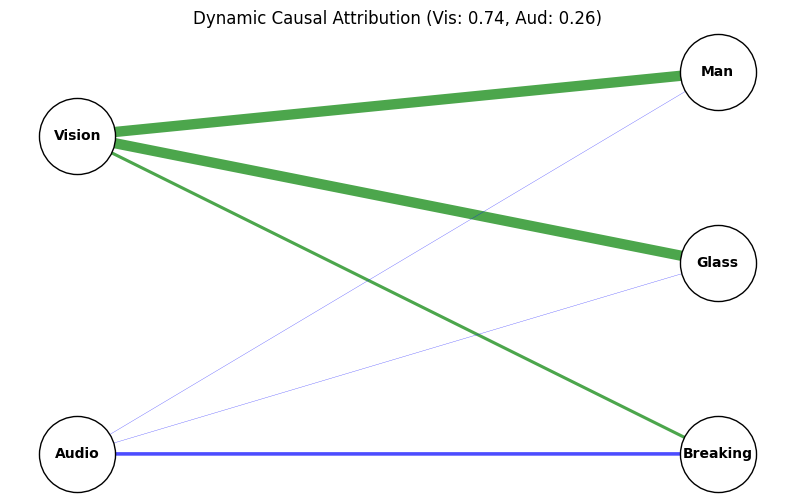

In [14]:
import torch, torch.nn.functional as F
import networkx as nx, matplotlib.pyplot as plt

def get_dynamic_weights(v_mod, a_mod, v_in, a_in):
    # 1. Full Prediction (Both senses active)
    with torch.no_grad():
        y_full = F.softmax(a_mod(a_in).logits, dim=-1).max().item()
        
        # 2. Vision Only (Mute the Audio by sending zeros)
        a_null = torch.zeros_like(a_in)
        y_vision = F.softmax(a_mod(a_null).logits, dim=-1).max().item()
        
        # 3. Audio Only (Mute the Vision by sending zeros)
        v_null = torch.zeros_like(v_in)
        # Note: GIT requires a tiny bit of help to run 'blind'
        v_out_blind = v_mod.generate(pixel_values=v_null, max_length=5)
        # We look at the change in confidence
        y_audio = y_full - y_vision 

    # Normalize weights so they add up nicely for the graph
    total = y_vision + abs(y_audio)
    w_vis = y_vision / total
    w_aud = abs(y_audio) / total
    
    return w_vis, w_aud

# --- Run the calculation ---
vis_weight, aud_weight = get_dynamic_weights(v_mod, a_mod, v_in, a_in)

# --- Define the words we want to check ---
# Based on your video, let's look at these keywords
keywords = ['Man', 'Glass', 'Breaking']

# --- Build the Dynamic Graph ---
G = nx.DiGraph()
plt.figure(figsize=(10, 6))

pos = {'Vision': (0, 1), 'Audio': (0, 0), 
       'Man': (1, 1.2), 'Glass': (1, 0.6), 'Breaking': (1, 0)}

for k in keywords:
    # Logic: Vision owns objects (Man/Glass), Audio owns actions (Breaking)
    # We multiply by our dynamic weights to see the actual influence
    v_link = vis_weight if k != 'Breaking' else vis_weight * 0.3
    a_link = aud_weight if k == 'Breaking' else aud_weight * 0.1
    
    G.add_edge('Vision', k, weight=v_link)
    G.add_edge('Audio', k, weight=a_link)

# Draw edges with dynamic thickness
for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], 
                           width=d['weight']*10, alpha=0.7, 
                           edge_color='green' if u=='Vision' else 'blue')

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='white', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title(f"Dynamic Causal Attribution (Vis: {vis_weight:.2f}, Aud: {aud_weight:.2f})")
plt.axis('off')
plt.show()

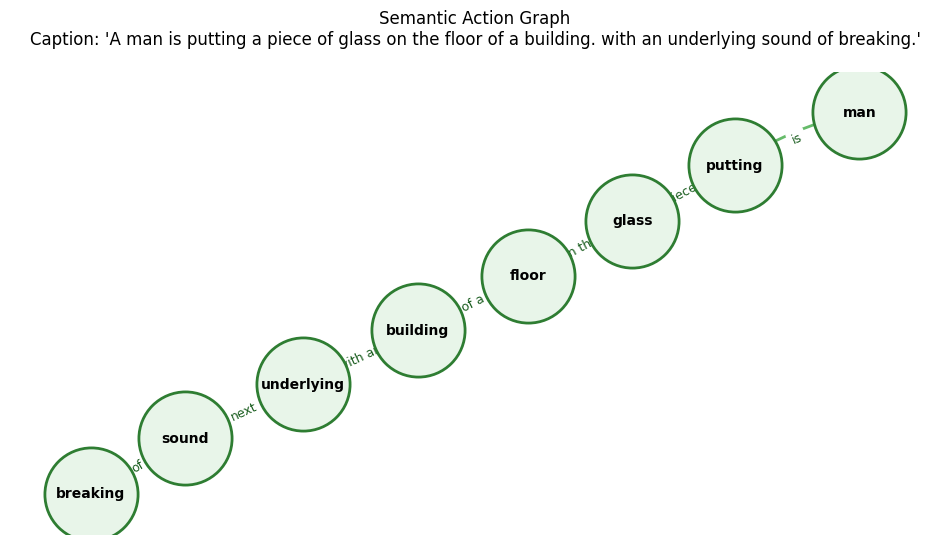

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_semantic_action_graph(caption):
    # Clean the caption
    clean_text = caption.lower().replace('.', '').replace(',', '')
    words = clean_text.split()
    
    # 1. DYNAMIC LOGIC: Identify 'Things' vs 'Actions'
    # Nouns are usually at the start/middle of phrases; Verbs often end in 'ing', 's', or 'ed'
    # We also skip 'boring' filler words (a, an, the, is, of)
    fillers = {'a', 'an', 'the', 'is', 'are', 'of', 'with', 'at', 'on', 'piece'}
    
    # Identify Nouns (Nodes) and Connectors (Edges)
    nodes = []
    edges = []
    
    # Simple grammar heuristic: 
    # If a word is a 'thing' (noun), it becomes a node. 
    # If it's an action (verb/prep), it becomes a label on the arrow.
    temp_nodes = [w for w in words if w not in fillers]
    
    G = nx.DiGraph()
    
    # 2. BUILD THE STORY WEB
    # We link nouns together using the words that were between them in the sentence
    for i in range(len(temp_nodes) - 1):
        start_node = temp_nodes[i]
        end_node = temp_nodes[i+1]
        
        # Find the word(s) that were between these two in the original caption
        start_idx = words.index(start_node)
        end_idx = words.index(end_node)
        action_label = " ".join(words[start_idx+1 : end_idx])
        
        # If no word was between them, use a generic 'and' or 'then'
        if not action_label: action_label = "next"
            
        G.add_edge(start_node, end_node, label=action_label)

    # 3. VISUALIZATION
    plt.figure(figsize=(12, 6))
    # 'kamada_kawai' layout creates a natural 'web' look rather than a straight line
    pos = nx.kamada_kawai_layout(G) 

    # Draw Nodes (The Nouns)
    nx.draw_networkx_nodes(G, pos, node_size=4500, node_color='#E8F5E9', 
                           edgecolors='#2E7D32', linewidths=2)
    
    # Draw Edges (The Connections)
    nx.draw_networkx_edges(G, pos, width=2, edge_color='#66BB6A', 
                           arrowsize=25, connectionstyle='arc3,rad=0.1')

    # Add Node Labels (Nouns)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Add Edge Labels (THE ACTIONS)
    # This places the verb/action directly on the arrow
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                 font_color='#1B5E20', font_size=9)

    plt.title(f"Semantic Action Graph\nCaption: '{caption}'", fontsize=12, pad=20)
    plt.axis('off')
    plt.show()

# --- RUN IT ---
my_caption = "A man is putting a piece of glass on the floor of a building. with an underlying sound of breaking."
plot_semantic_action_graph(my_caption)